# The data

In [27]:
import pandas as pd

countries = {'Italy', 'France', 'Spain', 'Germany', 'US'}
wine = pd.read_excel('../data/wine_reviews.xlsx', encoding='utf8')
data = wine[wine.country.isin(countries)]

In [99]:
# shuffle the data
data = data[data['description_cleaned'].isna() == False]
data = data.sample(frac=1)[:20000]

N = len(data)
train_size = int(N*0.5)
dev_size = int(N*0.25)
test_size = int(N*0.25)

train = data[:train_size]
dev = data[train_size: train_size+dev_size]
test = data[train_size+dev_size:]
print(len(train), len(dev), len(test))

10000 5000 5000


In [186]:
train.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_cleaned
66165,66165,66167,US,"This is supersaturated, dense and decadent wit...",Lachini Vineyard,93,42.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sineann,be supersaturat dense decadent sweet jammy bla...
51326,51326,51328,Italy,Here's a fresh style of Barbera with bright fr...,Rubia,86,NaN,Piedmont,Barbera del Monferrato,NaN,Barbera,Bottazza,here be fresh style bright fruit note that rec...
25484,25484,25486,US,This is made from declassified barrels origina...,YesOuiSi Red,87,18.0,Washington,Yakima Valley,Columbia Valley,Red Blend,Stevens,be make declassify barrel originally intend be...
140557,140557,140562,US,"Super-rich in tropical fruit, pineapple, apric...",Gravelstone,84,13.0,California,Monterey,Central Coast,Chardonnay,Jekel,super rich tropical fruit pineapple apricot pe...
109352,109352,109355,Italy,"Light as a feather and delicately fragrant, th...",Extra Dry,87,NaN,Veneto,Prosecco di Conegliano e Valdobbiadene,NaN,Prosecco,Vettori,light feather delicately fragrant luminous be ...


# The Labels

In [100]:
from sklearn.preprocessing import LabelEncoder

target = 'country'

# transform labels into numbers
labels2numbers = LabelEncoder()

y_train = labels2numbers.fit_transform(train[target])

print(labels2numbers.classes_)
print(data[target][:10], y[:10])

['France' 'Germany' 'Italy' 'Spain' 'US']
66165         US
51326      Italy
25484         US
140557        US
109352     Italy
34579         US
5565      France
99077      Italy
138572    France
97623         US
Name: country, dtype: object [4 4 0 3 4 4 4 4 4 2]


In [187]:
labels2numbers.inverse_transform([2,3,4])

array(['Italy', 'Spain', 'US'], dtype=object)

In [101]:
# transform dev and test with the same label converter
y_dev = labels2numbers.transform(dev[target])
y_test = labels2numbers.transform(test[target])

Let's look at the label distributions

In [102]:
from collections import Counter
{labels2numbers.classes_[k]: v/len(y_train) for k, v in Counter(y_train).items()}

{'US': 0.5318,
 'Italy': 0.1992,
 'France': 0.1789,
 'Spain': 0.0702,
 'Germany': 0.0199}

In [103]:
{labels2numbers.classes_[k]: v/len(y_dev) for k, v in Counter(y_dev).items()}

{'Italy': 0.204,
 'US': 0.5186,
 'France': 0.18,
 'Germany': 0.0208,
 'Spain': 0.0766}

In [188]:
{labels2numbers.classes_[k]: v/len(y_test) for k, v in Counter(y_test).items()}

{'US': 0.5422,
 'Italy': 0.1898,
 'France': 0.185,
 'Germany': 0.0186,
 'Spain': 0.0644}

# Transforming the Input

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word')

X_train = vectorizer.fit_transform(train['description_cleaned'])
print(X_train.shape)

(10000, 4938)


In [190]:
X_dev = vectorizer.transform(dev['description_cleaned'])
X_test = vectorizer.transform(test['description_cleaned'])
print(X_dev.shape, X_test.shape)

(5000, 4938) (5000, 4938)


# Dummy Baseline

In [191]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)
dumb_predictions = most_frequent.predict(X_dev)

print(classification_report(y_dev, dumb_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       900
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00      1020
           3       0.00      0.00      0.00       383
           4       0.52      1.00      0.68      2593

    accuracy                           0.52      5000
   macro avg       0.10      0.20      0.14      5000
weighted avg       0.27      0.52      0.35      5000



/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# A Classifier

In [192]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs')
%time classifier.fit(X_train, y_train)
print(classifier)

CPU times: user 67.4 ms, sys: 156 ms, total: 224 ms
Wall time: 5.58 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [193]:
predictions = classifier.predict(X_dev)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       900
           1       0.72      0.12      0.21       104
           2       0.94      0.90      0.92      1020
           3       0.88      0.70      0.78       383
           4       0.86      0.98      0.92      2593

    accuracy                           0.89      5000
   macro avg       0.87      0.70      0.74      5000
weighted avg       0.89      0.89      0.88      5000



# Getting better

# A better classifier

In [200]:
classifier_balanced = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                         class_weight='balanced')
%time classifier_balanced.fit(X_train, y_train)
predictions_balanced = classifier_balanced.predict(X_dev)

print(classification_report(y_dev, predictions_balanced))

predictions_balanced_test = classifier_balanced.predict(X_test)
print(classification_report(y_test, predictions_balanced_test))

CPU times: user 57.7 ms, sys: 130 ms, total: 188 ms
Wall time: 1.9 s
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       900
           1       0.42      0.82      0.56       104
           2       0.92      0.92      0.92      1020
           3       0.74      0.92      0.82       383
           4       0.96      0.90      0.93      2593

    accuracy                           0.89      5000
   macro avg       0.78      0.88      0.82      5000
weighted avg       0.91      0.89      0.90      5000

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       925
           1       0.40      0.75      0.52        93
           2       0.90      0.93      0.91       949
           3       0.71      0.90      0.79       322
           4       0.95      0.89      0.92      2711

    accuracy                           0.89      5000
   macro avg       0.77      0.87      0.80      5000
weighted

## Regularization strength

In [201]:
from sklearn.metrics import f1_score
best_c = None
best_performance = 0.0

for c in [50, 20, 10, 5, 2, 0.5, 0.1, 0.05, 0.01]:
    print(c)
    classifier_c = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                             class_weight='balanced',
                                             C=c
                                     )
    classifier_c.fit(X_train, y_train)
    predictions_c = classifier_c.predict(X_dev)
    score = f1_score(y_dev, predictions_c, average='micro')
    if score > best_performance:
        best_performance = score
        best_c = c
        print("New best performance: {}".format(score))
        
    print(classification_report(y_dev, predictions_c))
    print()

50
New best performance: 0.9068
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       900
           1       0.52      0.62      0.57       104
           2       0.93      0.92      0.92      1020
           3       0.82      0.87      0.84       383
           4       0.94      0.94      0.94      2593

    accuracy                           0.91      5000
   macro avg       0.82      0.84      0.83      5000
weighted avg       0.91      0.91      0.91      5000


20
New best performance: 0.9103999999999999
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       900
           1       0.52      0.65      0.58       104
           2       0.93      0.92      0.93      1020
           3       0.81      0.89      0.85       383
           4       0.94      0.94      0.94      2593

    accuracy                           0.91      5000
   macro avg       0.82      0.85      0.83      5000


In [204]:
classifier_c = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                         class_weight='balanced',
                                         C=best_c
                                 )
classifier_c.fit(X_train, y_train)

predictions_c_dev = classifier_c.predict(X_dev)
predictions_c_test = classifier_c.predict(X_test)

print(classification_report(y_test, predictions_c_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       925
           1       0.49      0.53      0.51        93
           2       0.92      0.93      0.92       949
           3       0.79      0.88      0.83       322
           4       0.94      0.93      0.94      2711

    accuracy                           0.91      5000
   macro avg       0.81      0.83      0.82      5000
weighted avg       0.91      0.91      0.91      5000



## 1. Feature selection

In [199]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=4500).fit(X_train, y_train)

X_train_sel = selector.transform(X_train)
X_dev_sel = selector.transform(X_dev)
X_test_sel = selector.transform(X_test)

print(X_train_sel.shape, X_dev_sel.shape, X_test_sel.shape)

(10000, 4500) (5000, 4500) (5000, 4500)


In [203]:
classifier_sel = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                    class_weight='balanced')
classifier_sel.fit(X_train_sel, y_train)

predictions_sel = classifier_sel.predict(X_dev_sel)
print(classification_report(y_dev, predictions_sel))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       900
           1       0.43      0.85      0.57       104
           2       0.92      0.92      0.92      1020
           3       0.73      0.92      0.82       383
           4       0.96      0.90      0.93      2593

    accuracy                           0.89      5000
   macro avg       0.78      0.89      0.82      5000
weighted avg       0.91      0.89      0.90      5000



## 2. Dimensionality reduction

In [156]:
from sklearn.decomposition import TruncatedSVD

for k in [100, 300, 500, 1000, 1500, 2000, 2500]:
    print(k)
    svd = TruncatedSVD(n_components=k)

    X_train_dim = svd.fit_transform(X_train_sel)
    X_dev_dim = svd.transform(X_dev_sel)
    X_test_dim = svd.transform(X_test_sel)

    classifier_dim = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                        class_weight='balanced')
    classifier_dim.fit(X_train_dim, y_train)

    predictions_dim = classifier_dim.predict(X_dev_dim)
    print(classification_report(y_dev, predictions_dim))
    print()

100
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       900
           1       0.22      0.86      0.35       104
           2       0.86      0.87      0.87      1020
           3       0.58      0.83      0.68       383
           4       0.95      0.80      0.87      2593

    accuracy                           0.81      5000
   macro avg       0.69      0.83      0.72      5000
weighted avg       0.87      0.81      0.83      5000


300
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       900
           1       0.29      0.88      0.44       104
           2       0.90      0.89      0.89      1020
           3       0.63      0.87      0.73       383
           4       0.95      0.84      0.89      2593

    accuracy                           0.85      5000
   macro avg       0.72      0.86      0.76      5000
weighted avg       0.88      0.85      0.86      5000


500
        

# Significance Testing

In [182]:
import numpy as np
from sklearn.metrics import f1_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [213]:
p_value, deltas = bootstrap_sample(predictions, dumb_predictions, y_dev)
print(p_value, p_value < 0.01)

0.0 True


In [212]:
print(f1_score(y_dev, dumb_predictions, average='micro'), f1_score(y_dev, predictions_c_dev, average='micro'))

0.5186 0.9103999999999999


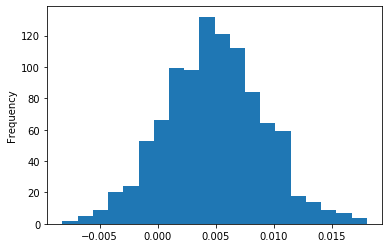

In [211]:
%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)

In [181]:
samples

1000